In [1]:
#################################################
!pip3 install face_recognition

     |████████████████████████████████| 100.2MB 31kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=35aec062d45af17f5e00b0ed9a5823a704e9058189a4a95a8f30026718e64d7c
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/DeepLearning/FaceNet

/content/drive/My Drive/DeepLearning/FaceNet


In [4]:
import cv2 
import os 
import numpy as np 
from face_recognition import face_locations, load_image_file
import glob 
import pickle

In [5]:
def loadModel(model_path):
    # Model was trained on PyTorch 
    # So we must load model to openCV 
    model = cv2.dnn.readNetFromTorch(model_path)
    return model

In [6]:
# Convert original image to blob image to reduce noise for photo due to lighting 
def blobImage(img, scale_factor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0)):
    # Use bloFromImages for batches, load and process multiple images
    imageBlob = cv2.dnn.blobFromImage(img, scalefactor=scale_factor, 
                                    size=size, mean=mean, swapRB=False)
    return imageBlob

In [70]:
def faceRecognition(img_path, single=True):
    faces = load_image_file(img_path)
    # faces = face_locations(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    name = img_path.split('/')[-1].split('.')[0]
    if name not in labels:
        labels.append(name)
    label = labels.index(name)
    return faces, label

In [46]:
def savePickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def loadPickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj 

In [9]:
!wget https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/YALE.tar.gz

--2020-07-03 06:00:01--  https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/YALE.tar.gz
Resolving vismod.media.mit.edu (vismod.media.mit.edu)... 18.27.72.36
Connecting to vismod.media.mit.edu (vismod.media.mit.edu)|18.27.72.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30032961 (29M) [application/x-gzip]
Saving to: ‘YALE.tar.gz.1’

YALE.tar.gz.1       100%[===================>]  28.64M  17.4MB/s    in 1.6s    

2020-07-03 06:00:03 (17.4 MB/s) - ‘YALE.tar.gz.1’ saved [30032961/30032961]



In [ ]:
# !tar -xf YALE.tar.gz

In [13]:
!ls ./YALE/centered

subject01.centerlight.pgm  subject06.centerlight.pgm  subject11.centerlight.pgm
subject01.glasses.pgm	   subject06.glasses.pgm      subject11.glasses.pgm
subject01.happy.pgm	   subject06.happy.pgm	      subject11.happy.pgm
subject01.leftlight.pgm    subject06.leftlight.pgm    subject11.leftlight.pgm
subject01.noglasses.pgm    subject06.noglasses.pgm    subject11.noglasses.pgm
subject01.normal.pgm	   subject06.normal.pgm       subject11.normal.pgm
subject01.rightlight.pgm   subject06.rightlight.pgm   subject11.rightlight.pgm
subject01.sad.pgm	   subject06.sad.pgm	      subject11.sad.pgm
subject01.sleepy.pgm	   subject06.sleepy.pgm       subject11.sleepy.pgm
subject01.surprised.pgm    subject06.surprised.pgm    subject11.surprised.pgm
subject01.wink.pgm	   subject06.wink.pgm	      subject11.wink.pgm
subject02.centerlight.pgm  subject07.centerlight.pgm  subject12.centerlight.pgm
subject02.glasses.pgm	   subject07.glasses.pgm      subject12.glasses.pgm
subject02.happy.pgm	   subject07.happ

In [71]:
imgs_path = glob.glob('./YALE/centered/*.pgm')

labels = []
print(f"Number of images : {len(imgs_path)}")
num = 0; all_faces = []
all_links = []; all_labels = []
for img_path in imgs_path:
    out, label = faceRecognition(img_path)
    num += 1 
    all_faces.append(out)
    all_labels.append(label)
    all_links.append(img_path)

Number of images : 165


In [72]:
# Use pretrain to get embedding vectors from images
def embeddingFaces(encoder, faces):
    embed_vecs = []
    for face in faces:
        faceBlob = blobImage(face, size=(96, 96), scale_factor=1/255.0, mean=(0, 0, 0))
        encoder.setInput(faceBlob)
        vec = encoder.forward()
        embed_vecs.append(vec)
    return embed_vecs

model = loadModel('./nn4.small2.v1.t7')
embed_faces = embeddingFaces(model, all_faces)
embed_faces[0].shape

(1, 128)

In [73]:
savePickle(all_faces, './Dataset/faces.pkl')
savePickle(all_labels, './Dataset/labels.pkl')
savePickle(all_links, './Dataset/links.pkl')
savePickle(embed_faces, './Dataset/embed_faces.pkl')

In [74]:
from sklearn.model_selection import train_test_split

ids = np.arange(len(all_faces))
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(np.stack(embed_faces), all_labels, 
                                                                         ids, test_size=0.2, stratify=all_labels)
X_train = np.squeeze(X_train, axis=1)
X_test = np.squeeze(X_test, axis=1)

In [75]:
print(f"Number of training data : {len(X_train)}")
print(f"Number of testing data : {len(X_test)}")

Number of training data : 132
Number of testing data : 33


In [76]:
savePickle(ids_train, './Dataset/ids_train.pkl')
savePickle(ids_test, './Dataset/ids_test.pkl')

In [77]:
from sklearn.metrics.pairwise import cosine_similarity

def k_most_similarity(X, vec, y, k):
    simi = cosine_similarity(X, vec)
    simi = simi.squeeze(1)
    ids = simi.argsort()[-k:][::-1]
    counts = np.zeros_like(labels, dtype=int)
    for idx in ids:
        counts[y[idx]] += 1
    return counts.argmax()
#     idx = simi.argmax()
#     return y[idx]

vec = X_test[1].reshape(1, -1)
print(k_most_similarity(X_train, vec, y_train, 1))

5


In [78]:
# LOAD ALL DATA 
all_faces = loadPickle('./Dataset/faces.pkl')
all_labels = loadPickle('./Dataset/labels.pkl')
all_links = loadPickle('./Dataset/links.pkl')
embed_faces = loadPickle('./Dataset/embed_faces.pkl')
ids_train = loadPickle('./Dataset/ids_train.pkl')
ids_test = loadPickle('./Dataset/ids_test.pkl')

X_train = []; X_test = []
y_train = []; y_test = []

for idx in ids_train:
    X_train.append(embed_faces[idx])
    y_train.append(all_labels[idx])
for idx in ids_test:
    X_test.append(embed_faces[idx])
    y_test.append(all_labels[idx])

X_train, X_test = np.stack(X_train), np.stack(X_test)
X_train, X_test = X_train.squeeze(1), X_test.squeeze(1)

In [80]:
from sklearn.metrics import accuracy_score 

def results(k_most, vecs_train, vecs_pred):
  y_preds = []
  for vec in vecs_pred:
      vec = vec.reshape(1, -1)
      y_pred = k_most_similarity(vecs_train, vec, y_train, k_most)
      y_preds.append(y_pred)

  return accuracy_score(y_preds, y_test)

print(f"The accuracy of selecting one most similar vectors : {results(1, X_train, X_test)}")
print(f"The accuracy of selecting five most similar vectors : {results(5, X_train, X_test)}")

The accuracy of selecting one most similar vectors : 0.8787878787878788
The accuracy of selecting five most similar vectors : 0.8181818181818182


In [25]:
################################################################################
#     USE VGG19 TO FEATURE ENGINEERING EXTRACT 128 VECTORS                     #
################################################################################

In [26]:
!pip3 install keras
!pip3 install tensorflow

In [81]:
from tensorflow.keras.layers import Dense, Flatten, Lambda
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam 
import tensorflow as tf
def build_model():
    model = VGG16(include_top=True, weights=None)
    dense = Dense(128)(model.layers[-4].output)
    norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense)
    model = Model(inputs=[model.input], outputs=[norm2])
    return model 

model = build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [82]:
def resize_image(faces):
    face_rs = []
    for face in faces:
        face = cv2.resize(face, dsize=(224, 224))
        face_rs.append(face)
    return face_rs 

all_faces = loadPickle('./Dataset/faces.pkl')
all_faces = resize_image(all_faces)

In [29]:
!pip3 install tensorflow_addons

In [83]:
import tensorflow_addons as tfa 
model.compile(optimizer=Adam(0.001),
             loss=tfa.losses.TripletSemiHardLoss())

In [84]:
all_faces = np.stack(all_faces)
all_faces.shape

(165, 224, 224, 3)

In [85]:
ids_train = loadPickle('./Dataset/ids_train.pkl')
ids_test = loadPickle('./Dataset/ids_test.pkl')

all_labels = loadPickle('./Dataset/labels.pkl')
all_labels = np.array(all_labels)
# X_train = all_faces[ids_train]/127.5 - 1
# X_test = all_faces[ids_test]/127.5 -1
X_train = all_faces[ids_train]
X_test = all_faces[ids_test]

y_train = all_labels[ids_train]
y_test = all_labels[ids_test]

In [86]:
X_train.shape

(132, 224, 224, 3)

In [87]:
gen_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(1024).batch(32)

In [88]:
# history = model.fit(X_train, y_train, batch_size=1, epochs=50)
history = model.fit(
    gen_train,
    steps_per_epoch = 50,
    epochs=10)

Epoch 1/10
50/50 [==============================] - 41s 818ms/step - loss: 0.9689
Epoch 2/10
50/50 [==============================] - 41s 810ms/step - loss: 0.8011
Epoch 3/10
50/50 [==============================] - 40s 809ms/step - loss: 0.5197
Epoch 4/10
50/50 [==============================] - 40s 806ms/step - loss: 0.1806
Epoch 5/10
50/50 [==============================] - 40s 799ms/step - loss: 0.0273
Epoch 6/10
50/50 [==============================] - 40s 797ms/step - loss: 0.0116
Epoch 7/10
50/50 [==============================] - 40s 793ms/step - loss: 0.0055
Epoch 8/10
50/50 [==============================] - 39s 787ms/step - loss: 3.0003e-04
Epoch 9/10
50/50 [==============================] - 39s 789ms/step - loss: 3.6592e-04
Epoch 10/10
50/50 [==============================] - 39s 788ms/step - loss: 7.0336e-06


In [89]:
vecs_train = model.predict(X_train)
vecs_pred = model.predict(X_test)

In [90]:
print(f"The accuracy of selecting one most similar vectors : {results(1, vecs_train, vecs_pred)}")
print(f"The accuracy of selecting five most similar vectors : {results(5, vecs_train, vecs_pred)}")
print(f"The accuracy of selecting ten most similar vectors : {results(10, vecs_train, vecs_pred)}")

The accuracy of selecting one most similar vectors : 0.9393939393939394
The accuracy of selecting five most similar vectors : 0.9393939393939394
The accuracy of selecting ten most similar vectors : 0.9393939393939394


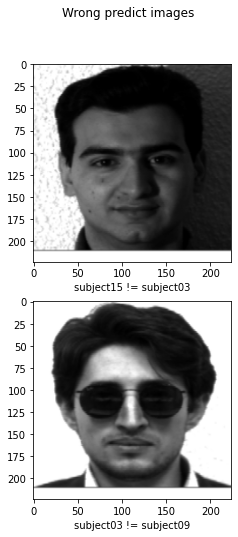

In [103]:
import matplotlib.pyplot as plt

y_preds = []
for vec in vecs_pred:
    vec = vec.reshape(1, -1)
    y_pred = k_most_similarity(vecs_train, vec, y_train, 1)
    y_preds.append(y_pred)

idx_diff = np.flatnonzero(np.array(y_preds) != np.array(y_test))

fg, ax = plt.subplots(2, 1, figsize=(4, 8))
fg.suptitle('Wrong predict images')

# imgs = np.array((X_test+1)*127.5, dtype=int)

for i in np.arange(2):
    ax[i].imshow(X_test[idx_diff[i]])
    ax[i].set_xlabel(f'{labels[y_test[idx_diff[i]]]} != {labels[y_preds[idx_diff[i]]]}')
    # ax[i, j].axis('off')

In [ ]:
###############################################################################
#                     USE DATA AUGMENTATION                                   #
###############################################################################

In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [106]:
no_batch = 0
X_au = []
y_au = []
for i in np.arange(len(X_train)):
  no_img = 0
  for x in datagen.flow(np.expand_dims(X_train[i], axis = 0), batch_size = 1):
    X_au.append(x[0])
    y_au.append(y_train[i])
    no_img += 1
    if no_img == 5:
      break

In [107]:
import tensorflow_addons as tfa
model2 = build_model()

model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [108]:
gen_train2 = tf.data.Dataset.from_tensor_slices((X_au, y_au)).repeat().shuffle(1024).batch(64)
gen_train2

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [109]:
history = model2.fit(
    gen_train2,
    steps_per_epoch = 50,
    epochs=20)

Epoch 1/20
50/50 [==============================] - 85s 2s/step - loss: 0.9684
Epoch 2/20
50/50 [==============================] - 85s 2s/step - loss: 0.9663
Epoch 3/20
50/50 [==============================] - 85s 2s/step - loss: 0.9501
Epoch 4/20
50/50 [==============================] - 84s 2s/step - loss: 0.9299
Epoch 5/20
50/50 [==============================] - 84s 2s/step - loss: 0.9094
Epoch 6/20
50/50 [==============================] - 84s 2s/step - loss: 0.8430
Epoch 7/20
50/50 [==============================] - 84s 2s/step - loss: 0.7641
Epoch 8/20
50/50 [==============================] - 84s 2s/step - loss: 0.6910
Epoch 9/20
50/50 [==============================] - 84s 2s/step - loss: 0.5540
Epoch 10/20
50/50 [==============================] - 84s 2s/step - loss: 0.4437
Epoch 11/20
50/50 [==============================] - 84s 2s/step - loss: 0.3009
Epoch 12/20
50/50 [==============================] - 84s 2s/step - loss: 0.1930
Epoch 13/20
50/50 [==============================

In [114]:
data_tf = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True
    )

data_tf.fit(X_test)

no_batch = 0
X_test_tf = []
for i in np.arange(len(X_test)):
  no_img = 0
  for x in data_tf.flow(np.expand_dims(X_test[i], axis = 0), batch_size = 1):
    X_test_tf.append(x[0])
    no_img += 1
    if no_img == 1:
      break

In [111]:
vecs_train = model2.predict(np.stack(X_au))
vecs_pred = model2.predict(np.stack(X_test_tf))

In [112]:
def results(k_most, vecs_train, vecs_pred):
  y_preds = []
  for vec in vecs_pred:
      vec = vec.reshape(1, -1)
      y_pred = k_most_similarity(vecs_train, vec, y_au, k_most)
      y_preds.append(y_pred)

  return accuracy_score(y_preds, y_test)

In [113]:
print(f"The accuracy of selecting one most similar vectors : {results(1, vecs_train, vecs_pred)}")
print(f"The accuracy of selecting five most similar vectors : {results(5, vecs_train, vecs_pred)}")
print(f"The accuracy of selecting ten most similar vectors : {results(10, vecs_train, vecs_pred)}")

The accuracy of selecting one most similar vectors : 0.9696969696969697
The accuracy of selecting five most similar vectors : 0.9696969696969697
The accuracy of selecting ten most similar vectors : 0.9696969696969697
